# 1. Install Dependencies and Setup

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
import tensorflow as tf
import os

# 2. Remove dodgy images

In [11]:
import cv2
from PIL import Image


In [12]:
data_dir = 'data'

In [13]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [16]:
# for image_class in os.listdir(data_dir):
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try:
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts:
#                 print('image not in the extension list.')
#                 os.remove(image_path)
#         except Exception as e:
#             print('issues with image {}'.format(image_path))

for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_path):
        continue  # skip non-directory files
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        try:
            # Read image with cv2 (optional, can skip if not needed)
            img = cv2.imread(image_path)

            # Verify image using Pillow
            with Image.open(image_path) as im:
                im.verify()  # Will raise an exception if image is corrupted
                tip = im.format.lower()  # Get image format like 'jpeg', 'png'

            # Check if format is in allowed extensions
            if tip not in image_exts:
                print(f"Image not in allowed extensions: {image_path}")
                os.remove(image_path)

        except Exception as e:
            print(f"Issues with image {image_path}: {e}")
            os.remove(image_path)

# 3. Load Data

In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [18]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [19]:
data_iterator = data.as_numpy_iterator()

In [20]:
batch = data_iterator.next()

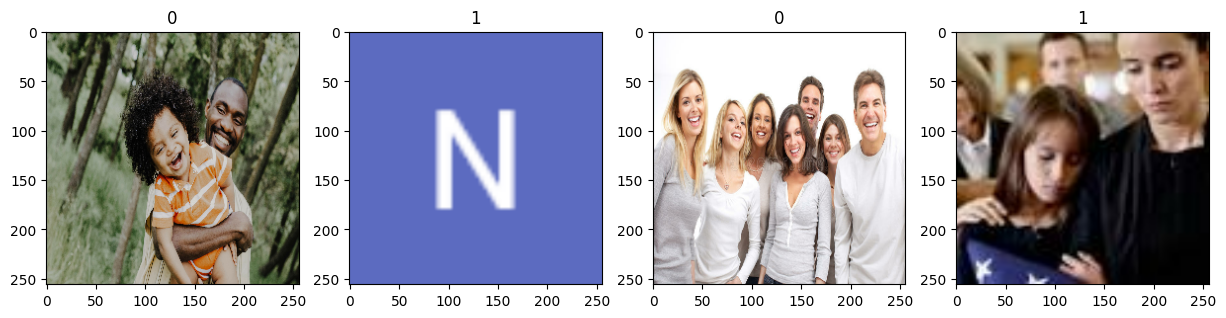

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(15,15))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [22]:
data = data.map(lambda x,y : (x/255, y))

In [23]:
data.as_numpy_iterator().next()

(array([[[[0.76367956, 0.8068168 , 0.81465995],
          [0.77936584, 0.8225031 , 0.8303462 ],
          [0.7955193 , 0.83865654, 0.8464997 ],
          ...,
          [0.40219438, 0.09631204, 0.0884689 ],
          [0.3647059 , 0.08039216, 0.06666667],
          [0.3509804 , 0.08431373, 0.0627451 ]],
 
         [[0.74972045, 0.7928577 , 0.808544  ],
          [0.76414675, 0.807284  , 0.8229703 ],
          [0.7719899 , 0.81512713, 0.8308134 ],
          ...,
          [0.39803922, 0.0882353 , 0.08235294],
          [0.36610752, 0.07591145, 0.06414675],
          [0.35224035, 0.07661229, 0.05952436]],
 
         [[0.7329159 , 0.77605313, 0.7917394 ],
          [0.7478094 , 0.79094666, 0.80663294],
          [0.76036686, 0.8035041 , 0.8191904 ],
          ...,
          [0.39136413, 0.0815602 , 0.07567785],
          [0.36862746, 0.07450981, 0.0627451 ],
          [0.35882354, 0.06862745, 0.05686275]],
 
         ...,
 
         [[0.69411767, 0.49411765, 0.37254903],
          [0.69411

# 5. Split Data

In [24]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [25]:
print(f'training data size (no. of batches) : {train_size}')
print(f'validation data size (no. of batches): {val_size}')
print(f'testing data size (no. of batches): {test_size}')

training data size (no. of batches) : 7
validation data size (no. of batches): 2
testing data size (no. of batches): 1


In [26]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Building the Deep Learning Model

In [27]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [29]:
model = Sequential()

In [30]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Training the Model

In [33]:
logdir = 'logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [35]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.5580 - loss: 0.7875 - val_accuracy: 0.4375 - val_loss: 0.7223
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.5938 - loss: 0.6768 - val_accuracy: 0.5625 - val_loss: 0.6149
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.6741 - loss: 0.5812 - val_accuracy: 0.8125 - val_loss: 0.4369
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.7545 - loss: 0.5209 - val_accuracy: 0.6562 - val_loss: 0.5814
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.8304 - loss: 0.4660 - val_accuracy: 0.8594 - val_loss: 0.4386
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.8571 - loss: 0.3767 - val_accuracy: 0.7656 - val_loss: 0.4281
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.8884 - loss: 0.2985 - val_accuracy: 0.9531 - val_loss: 0.2569
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - accuracy: 0.9464 - loss: 0.2199 - val_accuracy: 0.9844 - val_loss:

In [36]:
hist.history

{'accuracy': [0.5580357313156128,
  0.59375,
  0.6741071343421936,
  0.7544642686843872,
  0.8303571343421936,
  0.8571428656578064,
  0.8883928656578064,
  0.9464285969734192,
  0.9375,
  0.9508928656578064,
  0.9866071343421936,
  0.9866071343421936,
  0.9955357313156128,
  1.0,
  1.0,
  1.0,
  0.9955357313156128,
  0.9910714030265808,
  0.9910714030265808,
  0.9955357313156128],
 'loss': [0.787470817565918,
  0.6767618060112,
  0.581216037273407,
  0.5209246277809143,
  0.4660090506076813,
  0.37670883536338806,
  0.29845449328422546,
  0.21992728114128113,
  0.1870356947183609,
  0.15821193158626556,
  0.11022257804870605,
  0.058670852333307266,
  0.05168471485376358,
  0.03082549013197422,
  0.018445437774062157,
  0.005088579375296831,
  0.016918573528528214,
  0.0306360125541687,
  0.016093529760837555,
  0.013845154084265232],
 'val_accuracy': [0.4375,
  0.5625,
  0.8125,
  0.65625,
  0.859375,
  0.765625,
  0.953125,
  0.984375,
  0.984375,
  1.0,
  0.984375,
  1.0,
  0.98437

# 8. Evaluate Performance

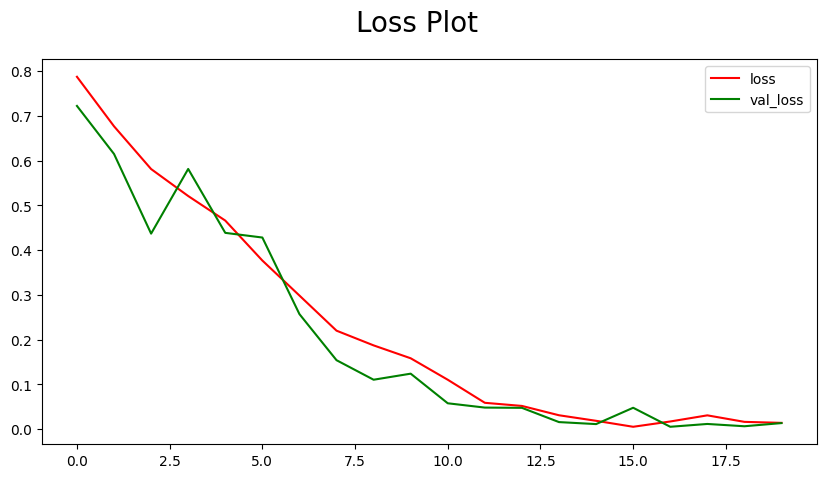

In [37]:
fig = plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'], color = 'red', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'green', label = 'val_loss')
fig.suptitle('Loss Plot', fontsize=20)
plt.legend(loc='upper right')
plt.show()

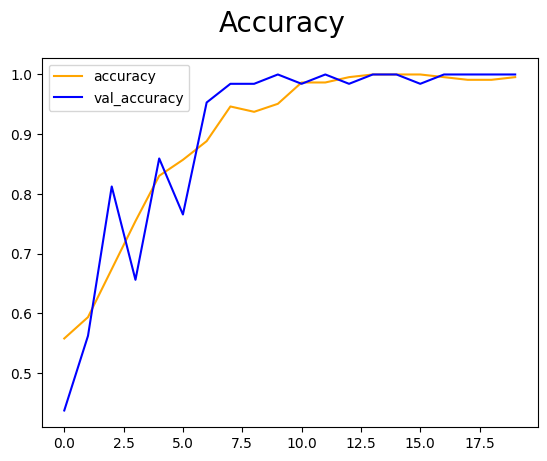

In [38]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='orange', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluating on the Test Partition 

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [41]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


In [42]:
print(f'Precision : {pre.result()} Recall : {re.result()} Accuracy : {acc.result()}')

Precision : 1.0 Recall : 1.0 Accuracy : 1.0


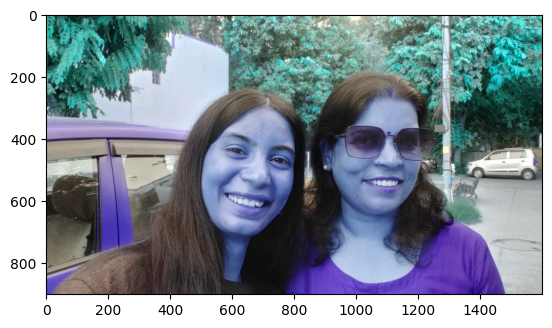

In [44]:
img = cv2.imread('test1.jpeg')
plt.imshow(img)
plt.show( )

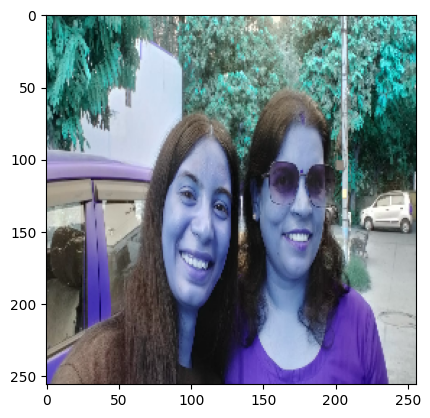

In [45]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [46]:
yhat1 = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


In [47]:
yhat1

array([[0.00803594]], dtype=float32)

In [48]:
if yhat1 > 0.5: 
    print(f'Predicted class is Sad.')
else:
    print(f'Predicted class is Happy.')

Predicted class is Happy.


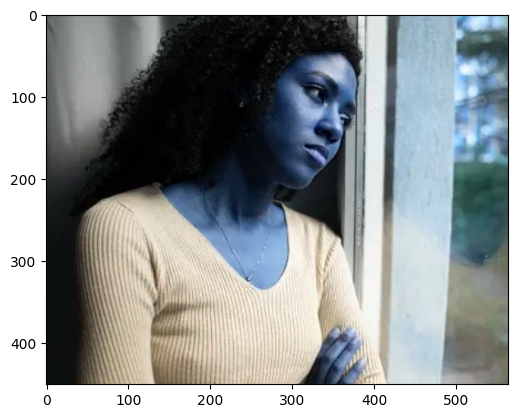

In [49]:
img = cv2.imread('test2.jpeg')
plt.imshow(img)
plt.show( )

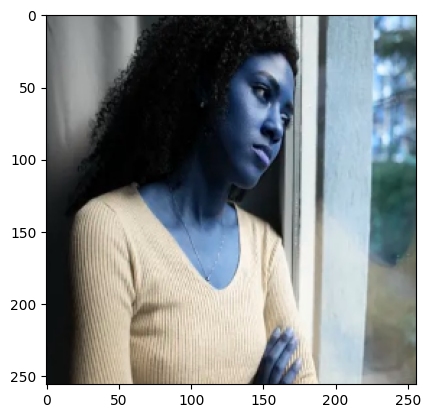

In [50]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [51]:
yhat2 = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [52]:
yhat2

array([[0.99839044]], dtype=float32)

In [53]:
if yhat2 > 0.5: 
    print(f'Predicted class is Sad.')
else:
    print(f'Predicted class is Happy.')

Predicted class is Sad.


# 10. Saving the Model

In [54]:
from tensorflow.keras.models import load_model

In [58]:
model.save(os.path.join('models', 'happy_sad_model.keras'))

In [61]:
newly_loaded_model = load_model(os.path.join('models', 'happy_sad_model.keras'))

In [62]:
newly_loaded_model

<Sequential name=sequential, built=True>